In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys

from google.colab import drive
drive.mount('/content/drive')
PROJECT_ROOT = '/content/drive/My Drive/d2d_channelprediction'
%mkdir '/content/drive/My Drive/d2d_channelprediction' -p
%cd '/content/drive/My Drive/d2d_channelprediction'
DATASETS_PATH = "data"
WORKING_PATH = "."
%mkdir $DATASETS_PATH -p

LOGDIR = f"{WORKING_PATH}/logs"
MODEL_VERSION = 'TEST'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/d2d_channelprediction


In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
from typing import Dict, NamedTuple, Union
from tqdm.notebook import tqdm
import logging
from matplotlib import pyplot as plt
import time
from itertools import product
import gc
import pathlib
from glob import glob
import pdb

from dateutil.relativedelta import relativedelta

In [4]:
class DataLoader:
  def __init__(self, path="data/", split='train'):
    self.path = path
    self.split = split
    ts_raw = pd.read_csv(os.path.join(path,f'{split}_d2d.csv')).iloc[:,1:].values.astype(np.float32)
    self.ts_raw = []
    
    for ts in ts_raw:
      self.ts_raw.append(ts[~np.isnan(ts)])


    self.ts_weight = np.zeros((len(self.ts_raw),), dtype=np.float32)
    for i,ts in enumerate(self.ts_raw):
      self.ts_weight[i] = len(ts)
    self.ts_weight = self.ts_weight / self.ts_weight.sum()

  def get_batch(self, batch_size=264, win_len=14*2, horizon=12, ts_sampling='uniform'):
  
    target_ts = np.zeros((batch_size, horizon), dtype=np.float32)
    history_ts = np.zeros((batch_size, win_len), dtype=np.float32)

    if ts_sampling == "uniform":
        ts_idxs = np.random.choice(np.arange(len(self.ts_raw)), size=batch_size, replace=True)
    elif ts_sampling == "ts_weight":
        ts_idxs = np.random.choice(np.arange(len(self.ts_raw)), size=batch_size, replace=True, p=self.ts_weight)
        
    for i, ts_id in enumerate(ts_idxs):
        ts = self.ts_raw[ts_id]
        sampling_point = np.random.choice(np.arange(win_len, len(ts)-horizon+1), size=1, replace=False)[0]
        history_ts[i,:] = ts[sampling_point-win_len:sampling_point]
        target_ts[i,:] = ts[sampling_point:sampling_point+horizon]

    batch = {"history": history_ts, "target": target_ts}
    return batch

  def get_sequential_batch(self, win_len=14*2):
    history_ts = np.zeros((len(self.ts_raw), win_len), dtype=np.float32)
    for i, ts in enumerate(self.ts_raw):
        history_ts[i,:] = ts[-win_len:]
    return {"history": history_ts}

train_dataset = DataLoader(path='data', split='train')
test_dataset = DataLoader(path='data', split='test')

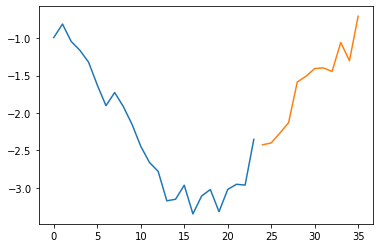

In [5]:
win_len=12*2
batch = train_dataset.get_batch(win_len=win_len, batch_size = 64)

plt.plot(batch["history"][0])
plt.plot(np.concatenate([np.nan*np.zeros((win_len,)), batch["target"][0]]))

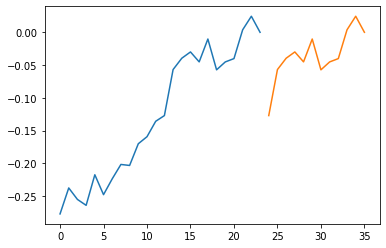

In [6]:
batch = train_dataset.get_sequential_batch()
id = 1

plt.plot(train_dataset.ts_raw[id][-24:])
plt.plot(np.concatenate([np.nan*np.zeros((24,)), test_dataset.ts_raw[id]]))

In [7]:
train_dataset.ts_raw[0].shape

(18114,)

In [8]:
test_dataset.ts_raw[0].shape

(12,)

In [9]:
HORIZON = 12

los_indoor = pd.read_csv('/content/fast_fading_dB_LOS_Head_Indoor_downsampled100hz_n50.txt', header=None, delimiter=r"\s+").dropna().T
los_outdoor = pd.read_csv('/content/fast_fading_dB_LOS_Head_Outdoor_downsampled100hz_n50.txt', header=None, delimiter=r"\s+").dropna().T
nlos_indoor = pd.read_csv('/content/fast_fading_dB_NLOS_Head_Indoor_downsampled100hz_n50.txt', header=None, delimiter=r"\s+").dropna().T
nlos_outdoor = pd.read_csv('/content/fast_fading_dB_NLOS_Head_Outdoor_downsampled100hz_n50.txt', header=None, delimiter=r"\s+").dropna().T

train_los_indoor = los_indoor[0:int(len(los_indoor - HORIZON))]
test_los_indoor = los_indoor[-int(HORIZON):].reset_index(drop=True)

train_los_outdoor = los_outdoor[0:int(len(los_indoor - HORIZON))]
test_los_outdoor = los_outdoor[-int(HORIZON):].reset_index(drop=True)

train_nlos_indoor = nlos_indoor[0:int(len(los_indoor - HORIZON))]
test_nlos_indoor = nlos_indoor[-int(HORIZON):].reset_index(drop=True)

train_nlos_outdoor = nlos_outdoor[0:int(len(los_indoor - HORIZON))]
test_nlos_outdoor = nlos_outdoor[-int(HORIZON):].reset_index(drop=True)

train_dataset = pd.concat([train_los_indoor, train_los_outdoor, train_nlos_indoor, train_nlos_outdoor], axis=1).T.reset_index(drop=True)
test_dataset = pd.concat([test_los_indoor, test_los_outdoor, test_nlos_indoor, test_nlos_outdoor], axis = 1).T.reset_index(drop=True)

In [18]:
import pandas as pd
from darts import TimeSeries

# Read a pandas DataFrame
df = train_nlos_indoor
df.index = pd.RangeIndex(start=0, stop=len(train_nlos_indoor), step=1, name='index')
df = df.reset_index(level=0)
df.columns = ['index', 'values']
# Create a TimeSeries, specifying the time and value columns
series = TimeSeries.from_dataframe(df,'index', 'values')

# Set aside the last 36 months as a validation series
train, val = series[:-12], series[-12:]

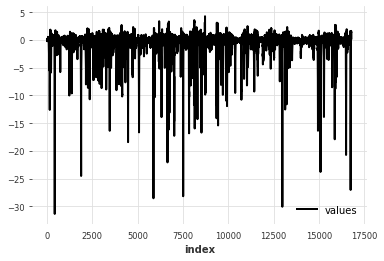

In [19]:
train.plot()

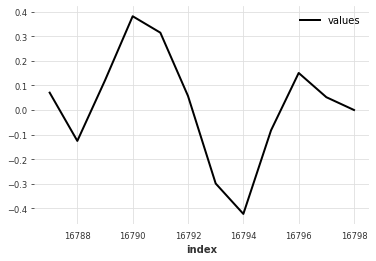

In [20]:
val.plot()

model ARIMA(12, 1, 0) obtains MAE: 0.15%


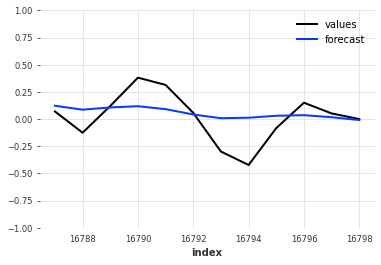

In [41]:
from darts.models import ARIMA
import matplotlib.pyplot as plt

model = ARIMA()
model.fit(train)
prediction_arima = model.predict(len(val))

val.plot()
prediction_arima.plot(label='forecast', new_plot=False, low_quantile=0.05, high_quantile=0.95)
plt.legend()
plt.ylim([-1, 1]);
print("model {} obtains MAE: {:.2f}".format(model, mae(val, prediction_arima)))

model LinearRegression(lags={'target': [-24, -23, -22, -21, -20, -19, -18, -17, -16, -15, -14, -13, -12, -11, -10, -9, -8, -7, -6, -5, -4, -3, -2, -1]}) obtains MAE: 0.59%


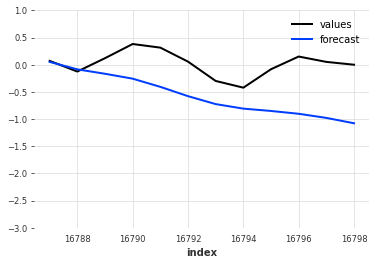

In [45]:
from darts.models import LinearRegressionModel
import matplotlib.pyplot as plt

model = LinearRegressionModel(lags=24)
model.fit(train)
prediction_lr = model.predict(len(val))

val.plot()
prediction_lr.plot(label='forecast', new_plot=False, low_quantile=0.05, high_quantile=0.95)
plt.legend()
plt.ylim([-3, 1]);
print("model {} obtains MAE: {:.2f}".format(model, mae(val, prediction_lr)))

model ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=12 obtains MAE: 1.18


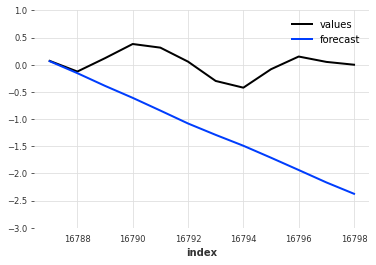

In [47]:
from darts.models import ExponentialSmoothing
import matplotlib.pyplot as plt

model = ExponentialSmoothing()
model.fit(train)
prediction_ets = model.predict(len(val))

val.plot()
prediction_ets.plot(label='forecast', new_plot=False, low_quantile=0.05, high_quantile=0.95)
plt.legend()
plt.ylim([-3, 1]);
print("model {} obtains MAE: {:.2f}".format(model, mae(val, prediction_ets)))

2022-08-02 20:37:06 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 16763 samples.
2022-08-02 20:37:06 darts.models.forecasting.torch_forecasting_model INFO: Time series values are 64-bits; casting model to float64.
2022-08-02 20:37:06 pytorch_lightning.utilities.rank_zero INFO: GPU available: True, used: False
2022-08-02 20:37:06 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-08-02 20:37:06 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-08-02 20:37:06 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:1817: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  category=PossibleUserWarning,
2022-08-02 20:37:06 pytorch_lightning.callbacks.model_summary INFO: 
  | Name          | Type             | Pa

Training: 0it [00:00, ?it/s]

Predicting: 524it [00:00, ?it/s]

model <darts.models.forecasting.rnn_model.RNNModel object at 0x7f808c246850> obtains MAE: 0.57


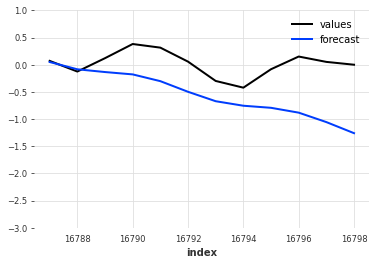

In [48]:
from darts.models import RNNModel
import matplotlib.pyplot as plt

model = RNNModel(input_chunk_length=24)
model.fit(train)
prediction_rnn = model.predict(len(val))

val.plot()
prediction_rnn.plot(label='forecast', new_plot=False, low_quantile=0.05, high_quantile=0.95)
plt.legend()
plt.ylim([-3, 1]);
print("model {} obtains MAE: {:.2f}".format(model, mae(val, prediction_rnn)))

model LinearRegression(n_jobs=-1) obtains MAE: 0.59


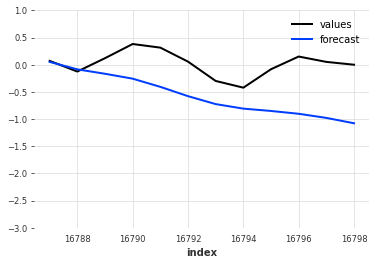

In [51]:
from darts.models import RegressionModel
import matplotlib.pyplot as plt

model = RegressionModel(lags=24)
model.fit(train)
prediction_lr = model.predict(len(val))

val.plot()
prediction_lr.plot(label='forecast', new_plot=False, low_quantile=0.05, high_quantile=0.95)
plt.legend()
plt.ylim([-3, 1]);
print("model {} obtains MAE: {:.2f}".format(model, mae(val, prediction_lr)))

2022-08-02 20:55:23 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 16752 samples.
2022-08-02 20:55:23 darts.models.forecasting.torch_forecasting_model INFO: Time series values are 64-bits; casting model to float64.
2022-08-02 20:55:23 pytorch_lightning.utilities.rank_zero INFO: GPU available: True, used: False
2022-08-02 20:55:23 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-08-02 20:55:23 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-08-02 20:55:23 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:1817: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  category=PossibleUserWarning,
2022-08-02 20:55:23 pytorch_lightning.callbacks.model_summary INFO: 
  | Name                | Type           

Training: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:726: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


Predicting: 138it [00:00, ?it/s]

model <darts.models.forecasting.transformer_model.TransformerModel object at 0x7f808bbbc790> obtains MAE: 0.59


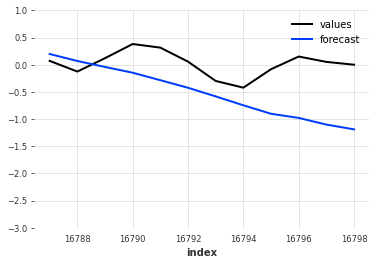

In [52]:
from darts.models import TransformerModel
import matplotlib.pyplot as plt

model = TransformerModel(input_chunk_length = 24, output_chunk_length = 12)
model.fit(train)
prediction_transf = model.predict(len(val))

val.plot()
prediction_transf.plot(label='forecast', new_plot=False, low_quantile=0.05, high_quantile=0.95)
plt.legend()
plt.ylim([-3, 1]);
print("model {} obtains MAE: {:.2f}".format(model, mae(val, prediction_lr)))

In [ ]:
# from darts.models import ExponentialSmoothing, TBATS, ARIMA, Theta, NBEATSModel, RNNModel


# def eval_model(model):
#     model.fit(train)
#     forecast = model.predict(len(val))
#     print("model {} obtains MAE: {:.2f}%".format(model, mae(val, forecast)))


# eval_model(ExponentialSmoothing())
# eval_model(TBATS())
# eval_model(ARIMA())
# eval_model(RNNModel(input_chunk_length=24, output_chunk_length=12, hidden_dim=50))
# # Theta(season_mode='additive')
# eval_model(NBEATSModel(input_chunk_length=24, output_chunk_length=12, random_state=42))

